In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from gplearn.genetic import SymbolicRegressor

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

tf.keras.backend.clear_session()

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../../_data/Kr2010.csv', index_col=0)
data_df['sbj'] -= 1

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_train = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_test = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(3522, 4) (3522, 4)


In [4]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + 0.1**14), axis=-1)

In [5]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
batch_size = X_train.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, obs_train))
train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=5000)

Epoch 1/5000
1/1 [==============================] - 1s 561ms/step - loss: 21629.8945
Epoch 2/5000
1/1 [==============================] - 0s 2ms/step - loss: 21527.3828
Epoch 3/5000
1/1 [==============================] - 0s 2ms/step - loss: 21453.7363
Epoch 4/5000
1/1 [==============================] - 0s 2ms/step - loss: 21392.4453
Epoch 5/5000
1/1 [==============================] - 0s 2ms/step - loss: 21338.3086
Epoch 6/5000
1/1 [==============================] - 0s 3ms/step - loss: 21288.9219
Epoch 7/5000
1/1 [==============================] - 0s 3ms/step - loss: 21242.9629
Epoch 8/5000
1/1 [==============================] - 0s 3ms/step - loss: 21199.6289
Epoch 9/5000
1/1 [==============================] - 0s 3ms/step - loss: 21158.3848
Epoch 10/5000
1/1 [==============================] - 0s 3ms/step - loss: 21118.8477
Epoch 11/5000
1/1 [==============================] - 0s 3ms/step - loss: 21080.7480
Epoch 12/5000
1/1 [==============================] - 0s 3ms/step - loss: 21043.8730

1/1 [==============================] - 0s 4ms/step - loss: 17343.7285
Epoch 195/5000
1/1 [==============================] - 0s 3ms/step - loss: 17332.2734
Epoch 196/5000
1/1 [==============================] - 0s 3ms/step - loss: 17320.8691
Epoch 197/5000
1/1 [==============================] - 0s 3ms/step - loss: 17309.5176
Epoch 198/5000
1/1 [==============================] - 0s 4ms/step - loss: 17298.2168
Epoch 199/5000
1/1 [==============================] - 0s 3ms/step - loss: 17286.9688
Epoch 200/5000
1/1 [==============================] - 0s 3ms/step - loss: 17275.7637
Epoch 201/5000
1/1 [==============================] - 0s 3ms/step - loss: 17264.6133
Epoch 202/5000
1/1 [==============================] - 0s 2ms/step - loss: 17253.5137
Epoch 203/5000
1/1 [==============================] - 0s 3ms/step - loss: 17242.4629
Epoch 204/5000
1/1 [==============================] - 0s 2ms/step - loss: 17231.4551
Epoch 205/5000
1/1 [==============================] - 0s 2ms/step - loss: 17220.

1/1 [==============================] - 0s 3ms/step - loss: 15400.8408
Epoch 387/5000
1/1 [==============================] - 0s 3ms/step - loss: 15387.5986
Epoch 388/5000
1/1 [==============================] - 0s 2ms/step - loss: 15374.4717
Epoch 389/5000
1/1 [==============================] - 0s 3ms/step - loss: 15361.4590
Epoch 390/5000
1/1 [==============================] - 0s 2ms/step - loss: 15348.5488
Epoch 391/5000
1/1 [==============================] - 0s 2ms/step - loss: 15335.7393
Epoch 392/5000
1/1 [==============================] - 0s 3ms/step - loss: 15323.0225
Epoch 393/5000
1/1 [==============================] - 0s 3ms/step - loss: 15310.3926
Epoch 394/5000
1/1 [==============================] - 0s 2ms/step - loss: 15297.8418
Epoch 395/5000
1/1 [==============================] - 0s 2ms/step - loss: 15285.3672
Epoch 396/5000
1/1 [==============================] - 0s 2ms/step - loss: 15272.9688
Epoch 397/5000
1/1 [==============================] - 0s 3ms/step - loss: 15260.

1/1 [==============================] - 0s 3ms/step - loss: 13451.0156
Epoch 579/5000
1/1 [==============================] - 0s 3ms/step - loss: 13442.3555
Epoch 580/5000
1/1 [==============================] - 0s 2ms/step - loss: 13433.6992
Epoch 581/5000
1/1 [==============================] - 0s 2ms/step - loss: 13425.0674
Epoch 582/5000
1/1 [==============================] - 0s 2ms/step - loss: 13416.4365
Epoch 583/5000
1/1 [==============================] - 0s 2ms/step - loss: 13407.8301
Epoch 584/5000
1/1 [==============================] - 0s 3ms/step - loss: 13399.2305
Epoch 585/5000
1/1 [==============================] - 0s 3ms/step - loss: 13390.6523
Epoch 586/5000
1/1 [==============================] - 0s 2ms/step - loss: 13382.0752
Epoch 587/5000
1/1 [==============================] - 0s 2ms/step - loss: 13373.5283
Epoch 588/5000
1/1 [==============================] - 0s 2ms/step - loss: 13364.9785
Epoch 589/5000
1/1 [==============================] - 0s 2ms/step - loss: 13356.

1/1 [==============================] - 0s 3ms/step - loss: 12058.6123
Epoch 771/5000
1/1 [==============================] - 0s 3ms/step - loss: 12052.4971
Epoch 772/5000
1/1 [==============================] - 0s 3ms/step - loss: 12046.5391
Epoch 773/5000
1/1 [==============================] - 0s 3ms/step - loss: 12040.6758
Epoch 774/5000
1/1 [==============================] - 0s 2ms/step - loss: 12034.8691
Epoch 775/5000
1/1 [==============================] - 0s 2ms/step - loss: 12028.8740
Epoch 776/5000
1/1 [==============================] - 0s 3ms/step - loss: 12022.7715
Epoch 777/5000
1/1 [==============================] - 0s 3ms/step - loss: 12016.5547
Epoch 778/5000
1/1 [==============================] - 0s 2ms/step - loss: 12010.4209
Epoch 779/5000
1/1 [==============================] - 0s 2ms/step - loss: 12004.3301
Epoch 780/5000
1/1 [==============================] - 0s 2ms/step - loss: 11998.3291
Epoch 781/5000
1/1 [==============================] - 0s 2ms/step - loss: 11992.

1/1 [==============================] - 0s 2ms/step - loss: 11077.9795
Epoch 963/5000
1/1 [==============================] - 0s 2ms/step - loss: 11073.6494
Epoch 964/5000
1/1 [==============================] - 0s 3ms/step - loss: 11069.1318
Epoch 965/5000
1/1 [==============================] - 0s 3ms/step - loss: 11064.7246
Epoch 966/5000
1/1 [==============================] - 0s 2ms/step - loss: 11060.3135
Epoch 967/5000
1/1 [==============================] - 0s 2ms/step - loss: 11056.0156
Epoch 968/5000
1/1 [==============================] - 0s 2ms/step - loss: 11051.7354
Epoch 969/5000
1/1 [==============================] - 0s 2ms/step - loss: 11047.5586
Epoch 970/5000
1/1 [==============================] - 0s 3ms/step - loss: 11043.4678
Epoch 971/5000
1/1 [==============================] - 0s 2ms/step - loss: 11039.7432
Epoch 972/5000
1/1 [==============================] - 0s 2ms/step - loss: 11036.7207
Epoch 973/5000
1/1 [==============================] - 0s 2ms/step - loss: 11033.

1/1 [==============================] - 0s 3ms/step - loss: 10415.1455
Epoch 1153/5000
1/1 [==============================] - 0s 2ms/step - loss: 10413.0146
Epoch 1154/5000
1/1 [==============================] - 0s 2ms/step - loss: 10411.4082
Epoch 1155/5000
1/1 [==============================] - 0s 2ms/step - loss: 10409.8301
Epoch 1156/5000
1/1 [==============================] - 0s 2ms/step - loss: 10406.5479
Epoch 1157/5000
1/1 [==============================] - 0s 3ms/step - loss: 10403.2305
Epoch 1158/5000
1/1 [==============================] - 0s 3ms/step - loss: 10399.8066
Epoch 1159/5000
1/1 [==============================] - 0s 2ms/step - loss: 10396.9033
Epoch 1160/5000
1/1 [==============================] - 0s 3ms/step - loss: 10394.1123
Epoch 1161/5000
1/1 [==============================] - 0s 2ms/step - loss: 10391.4912
Epoch 1162/5000
1/1 [==============================] - 0s 3ms/step - loss: 10388.9297
Epoch 1163/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 2ms/step - loss: 10047.0566
Epoch 1343/5000
1/1 [==============================] - 0s 2ms/step - loss: 10046.0557
Epoch 1344/5000
1/1 [==============================] - 0s 3ms/step - loss: 10045.9082
Epoch 1345/5000
1/1 [==============================] - 0s 3ms/step - loss: 10047.0410
Epoch 1346/5000
1/1 [==============================] - 0s 2ms/step - loss: 10046.1768
Epoch 1347/5000
1/1 [==============================] - 0s 3ms/step - loss: 10043.6875
Epoch 1348/5000
1/1 [==============================] - 0s 2ms/step - loss: 10040.3320
Epoch 1349/5000
1/1 [==============================] - 0s 2ms/step - loss: 10038.2920
Epoch 1350/5000
1/1 [==============================] - 0s 3ms/step - loss: 10036.5791
Epoch 1351/5000
1/1 [==============================] - 0s 2ms/step - loss: 10035.1338
Epoch 1352/5000
1/1 [==============================] - 0s 2ms/step - loss: 10033.8008
Epoch 1353/5000
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 9939.5518
Epoch 1439/5000
1/1 [==============================] - 0s 2ms/step - loss: 9939.5762
Epoch 1440/5000
1/1 [==============================] - 0s 2ms/step - loss: 9939.5654
Epoch 1441/5000
1/1 [==============================] - 0s 2ms/step - loss: 9939.1748
Epoch 1442/5000
1/1 [==============================] - 0s 2ms/step - loss: 9937.2725
Epoch 1443/5000
1/1 [==============================] - 0s 3ms/step - loss: 9935.9482
Epoch 1444/5000
1/1 [==============================] - 0s 2ms/step - loss: 9934.6855
Epoch 1445/5000
1/1 [==============================] - 0s 2ms/step - loss: 9933.9287
Epoch 1446/5000
1/1 [==============================] - 0s 2ms/step - loss: 9933.3311
Epoch 1447/5000
1/1 [==============================] - 0s 2ms/step - loss: 9932.1562
Epoch 1448/5000
1/1 [==============================] - 0s 3ms/step - loss: 9930.9941
Epoch 1449/5000
1/1 [==============================] - 0s 3ms/step - loss: 9929.6

1/1 [==============================] - 0s 3ms/step - loss: 9798.5039
Epoch 1631/5000
1/1 [==============================] - 0s 3ms/step - loss: 9798.6738
Epoch 1632/5000
1/1 [==============================] - 0s 3ms/step - loss: 9798.7764
Epoch 1633/5000
1/1 [==============================] - 0s 2ms/step - loss: 9797.1777
Epoch 1634/5000
1/1 [==============================] - 0s 3ms/step - loss: 9796.1992
Epoch 1635/5000
1/1 [==============================] - 0s 3ms/step - loss: 9794.8076
Epoch 1636/5000
1/1 [==============================] - 0s 2ms/step - loss: 9793.7266
Epoch 1637/5000
1/1 [==============================] - 0s 2ms/step - loss: 9793.6055
Epoch 1638/5000
1/1 [==============================] - 0s 2ms/step - loss: 9792.7568
Epoch 1639/5000
1/1 [==============================] - 0s 2ms/step - loss: 9792.8691
Epoch 1640/5000
1/1 [==============================] - 0s 3ms/step - loss: 9792.8018
Epoch 1641/5000
1/1 [==============================] - 0s 3ms/step - loss: 9792.7

1/1 [==============================] - 0s 2ms/step - loss: 9702.2627
Epoch 1823/5000
1/1 [==============================] - 0s 3ms/step - loss: 9699.0986
Epoch 1824/5000
1/1 [==============================] - 0s 3ms/step - loss: 9698.8145
Epoch 1825/5000
1/1 [==============================] - 0s 2ms/step - loss: 9696.4570
Epoch 1826/5000
1/1 [==============================] - 0s 2ms/step - loss: 9695.6494
Epoch 1827/5000
1/1 [==============================] - 0s 2ms/step - loss: 9694.7061
Epoch 1828/5000
1/1 [==============================] - 0s 2ms/step - loss: 9694.0361
Epoch 1829/5000
1/1 [==============================] - 0s 3ms/step - loss: 9697.0586
Epoch 1830/5000
1/1 [==============================] - 0s 2ms/step - loss: 9699.9023
Epoch 1831/5000
1/1 [==============================] - 0s 2ms/step - loss: 9698.3125
Epoch 1832/5000
1/1 [==============================] - 0s 2ms/step - loss: 9697.4766
Epoch 1833/5000
1/1 [==============================] - 0s 2ms/step - loss: 9695.0

1/1 [==============================] - 0s 4ms/step - loss: 9624.9600
Epoch 2015/5000
1/1 [==============================] - 0s 3ms/step - loss: 9624.9365
Epoch 2016/5000
1/1 [==============================] - 0s 3ms/step - loss: 9623.2080
Epoch 2017/5000
1/1 [==============================] - 0s 2ms/step - loss: 9622.6191
Epoch 2018/5000
1/1 [==============================] - 0s 3ms/step - loss: 9621.4629
Epoch 2019/5000
1/1 [==============================] - 0s 4ms/step - loss: 9622.3467
Epoch 2020/5000
1/1 [==============================] - 0s 3ms/step - loss: 9621.9219
Epoch 2021/5000
1/1 [==============================] - 0s 3ms/step - loss: 9623.4590
Epoch 2022/5000
1/1 [==============================] - 0s 3ms/step - loss: 9622.7666
Epoch 2023/5000
1/1 [==============================] - 0s 3ms/step - loss: 9622.1699
Epoch 2024/5000
1/1 [==============================] - 0s 3ms/step - loss: 9623.1494
Epoch 2025/5000
1/1 [==============================] - 0s 3ms/step - loss: 9622.2

1/1 [==============================] - 0s 3ms/step - loss: 9569.2393
Epoch 2209/5000
1/1 [==============================] - 0s 3ms/step - loss: 9567.5752
Epoch 2210/5000
1/1 [==============================] - 0s 3ms/step - loss: 9566.3721
Epoch 2211/5000
1/1 [==============================] - 0s 2ms/step - loss: 9566.2598
Epoch 2212/5000
1/1 [==============================] - 0s 3ms/step - loss: 9565.1611
Epoch 2213/5000
1/1 [==============================] - 0s 4ms/step - loss: 9565.1572
Epoch 2214/5000
1/1 [==============================] - 0s 3ms/step - loss: 9563.7139
Epoch 2215/5000
1/1 [==============================] - 0s 3ms/step - loss: 9566.3184
Epoch 2216/5000
1/1 [==============================] - 0s 3ms/step - loss: 9566.4473
Epoch 2217/5000
1/1 [==============================] - 0s 3ms/step - loss: 9564.7695
Epoch 2218/5000
1/1 [==============================] - 0s 3ms/step - loss: 9563.7324
Epoch 2219/5000
1/1 [==============================] - 0s 3ms/step - loss: 9564.0

1/1 [==============================] - 0s 3ms/step - loss: 9524.7998
Epoch 2401/5000
1/1 [==============================] - 0s 3ms/step - loss: 9523.9219
Epoch 2402/5000
1/1 [==============================] - 0s 2ms/step - loss: 9522.9365
Epoch 2403/5000
1/1 [==============================] - 0s 2ms/step - loss: 9523.2568
Epoch 2404/5000
1/1 [==============================] - 0s 3ms/step - loss: 9521.9736
Epoch 2405/5000
1/1 [==============================] - 0s 3ms/step - loss: 9524.0771
Epoch 2406/5000
1/1 [==============================] - 0s 2ms/step - loss: 9525.3633
Epoch 2407/5000
1/1 [==============================] - 0s 2ms/step - loss: 9524.1133
Epoch 2408/5000
1/1 [==============================] - 0s 2ms/step - loss: 9522.1533
Epoch 2409/5000
1/1 [==============================] - 0s 2ms/step - loss: 9520.7637
Epoch 2410/5000
1/1 [==============================] - 0s 3ms/step - loss: 9519.2666
Epoch 2411/5000
1/1 [==============================] - 0s 3ms/step - loss: 9517.5

1/1 [==============================] - 0s 3ms/step - loss: 9498.5801
Epoch 2593/5000
1/1 [==============================] - 0s 2ms/step - loss: 9492.7334
Epoch 2594/5000
1/1 [==============================] - 0s 3ms/step - loss: 9489.9365
Epoch 2595/5000
1/1 [==============================] - 0s 7ms/step - loss: 9486.8027
Epoch 2596/5000
1/1 [==============================] - 0s 4ms/step - loss: 9489.4131
Epoch 2597/5000
1/1 [==============================] - 0s 3ms/step - loss: 9487.2725
Epoch 2598/5000
1/1 [==============================] - 0s 3ms/step - loss: 9488.1064
Epoch 2599/5000
1/1 [==============================] - 0s 2ms/step - loss: 9486.8271
Epoch 2600/5000
1/1 [==============================] - 0s 2ms/step - loss: 9489.0254
Epoch 2601/5000
1/1 [==============================] - 0s 3ms/step - loss: 9488.9082
Epoch 2602/5000
1/1 [==============================] - 0s 2ms/step - loss: 9495.7646
Epoch 2603/5000
1/1 [==============================] - 0s 3ms/step - loss: 9498.6

1/1 [==============================] - 0s 3ms/step - loss: 9465.5977
Epoch 2785/5000
1/1 [==============================] - 0s 2ms/step - loss: 9462.4863
Epoch 2786/5000
1/1 [==============================] - 0s 2ms/step - loss: 9464.7012
Epoch 2787/5000
1/1 [==============================] - 0s 3ms/step - loss: 9466.2539
Epoch 2788/5000
1/1 [==============================] - 0s 2ms/step - loss: 9466.2305
Epoch 2789/5000
1/1 [==============================] - 0s 2ms/step - loss: 9467.8613
Epoch 2790/5000
1/1 [==============================] - 0s 2ms/step - loss: 9468.6270
Epoch 2791/5000
1/1 [==============================] - 0s 2ms/step - loss: 9469.6514
Epoch 2792/5000
1/1 [==============================] - 0s 3ms/step - loss: 9470.5400
Epoch 2793/5000
1/1 [==============================] - 0s 3ms/step - loss: 9467.8730
Epoch 2794/5000
1/1 [==============================] - 0s 2ms/step - loss: 9465.0439
Epoch 2795/5000
1/1 [==============================] - 0s 2ms/step - loss: 9462.4

Epoch 2881/5000
1/1 [==============================] - 0s 3ms/step - loss: 9453.9463
Epoch 2882/5000
1/1 [==============================] - 0s 2ms/step - loss: 9454.9600
Epoch 2883/5000
1/1 [==============================] - 0s 2ms/step - loss: 9454.2295
Epoch 2884/5000
1/1 [==============================] - 0s 2ms/step - loss: 9456.8008
Epoch 2885/5000
1/1 [==============================] - 0s 3ms/step - loss: 9458.7578
Epoch 2886/5000
1/1 [==============================] - 0s 3ms/step - loss: 9459.7803
Epoch 2887/5000
1/1 [==============================] - 0s 2ms/step - loss: 9459.7207
Epoch 2888/5000
1/1 [==============================] - 0s 2ms/step - loss: 9456.7822
Epoch 2889/5000
1/1 [==============================] - 0s 2ms/step - loss: 9456.0615
Epoch 2890/5000
1/1 [==============================] - 0s 3ms/step - loss: 9455.9189
Epoch 2891/5000
1/1 [==============================] - 0s 3ms/step - loss: 9452.2412
Epoch 2892/5000
1/1 [==============================] - 0s 3ms/ste

1/1 [==============================] - 0s 3ms/step - loss: 9441.5430
Epoch 3074/5000
1/1 [==============================] - 0s 2ms/step - loss: 9438.4365
Epoch 3075/5000
1/1 [==============================] - 0s 2ms/step - loss: 9438.3428
Epoch 3076/5000
1/1 [==============================] - 0s 2ms/step - loss: 9437.5674
Epoch 3077/5000
1/1 [==============================] - 0s 2ms/step - loss: 9435.2432
Epoch 3078/5000
1/1 [==============================] - 0s 3ms/step - loss: 9440.2031
Epoch 3079/5000
1/1 [==============================] - 0s 3ms/step - loss: 9438.7969
Epoch 3080/5000
1/1 [==============================] - 0s 2ms/step - loss: 9439.1445
Epoch 3081/5000
1/1 [==============================] - 0s 2ms/step - loss: 9438.7334
Epoch 3082/5000
1/1 [==============================] - 0s 2ms/step - loss: 9440.9912
Epoch 3083/5000
1/1 [==============================] - 0s 2ms/step - loss: 9436.2598
Epoch 3084/5000
1/1 [==============================] - 0s 3ms/step - loss: 9440.1

1/1 [==============================] - 0s 3ms/step - loss: 9423.6143
Epoch 3266/5000
1/1 [==============================] - 0s 3ms/step - loss: 9424.3564
Epoch 3267/5000
1/1 [==============================] - 0s 2ms/step - loss: 9426.6182
Epoch 3268/5000
1/1 [==============================] - 0s 2ms/step - loss: 9427.4541
Epoch 3269/5000
1/1 [==============================] - 0s 2ms/step - loss: 9432.0420
Epoch 3270/5000
1/1 [==============================] - 0s 3ms/step - loss: 9429.3945
Epoch 3271/5000
1/1 [==============================] - 0s 3ms/step - loss: 9429.3389
Epoch 3272/5000
1/1 [==============================] - 0s 2ms/step - loss: 9426.5400
Epoch 3273/5000
1/1 [==============================] - 0s 2ms/step - loss: 9427.9355
Epoch 3274/5000
1/1 [==============================] - 0s 2ms/step - loss: 9423.1865
Epoch 3275/5000
1/1 [==============================] - 0s 3ms/step - loss: 9426.8301
Epoch 3276/5000
1/1 [==============================] - 0s 3ms/step - loss: 9424.1

1/1 [==============================] - 0s 2ms/step - loss: 9413.2852
Epoch 3458/5000
1/1 [==============================] - 0s 2ms/step - loss: 9412.8105
Epoch 3459/5000
1/1 [==============================] - 0s 3ms/step - loss: 9411.2803
Epoch 3460/5000
1/1 [==============================] - 0s 2ms/step - loss: 9415.1279
Epoch 3461/5000
1/1 [==============================] - 0s 2ms/step - loss: 9411.4658
Epoch 3462/5000
1/1 [==============================] - 0s 2ms/step - loss: 9412.7959
Epoch 3463/5000
1/1 [==============================] - 0s 2ms/step - loss: 9410.3789
Epoch 3464/5000
1/1 [==============================] - 0s 2ms/step - loss: 9411.0908
Epoch 3465/5000
1/1 [==============================] - 0s 3ms/step - loss: 9412.1826
Epoch 3466/5000
1/1 [==============================] - 0s 2ms/step - loss: 9416.8496
Epoch 3467/5000
1/1 [==============================] - 0s 3ms/step - loss: 9419.0996
Epoch 3468/5000
1/1 [==============================] - 0s 2ms/step - loss: nan
Ep

1/1 [==============================] - 0s 2ms/step - loss: 9409.9473
Epoch 3651/5000
1/1 [==============================] - 0s 3ms/step - loss: 9408.5557
Epoch 3652/5000
1/1 [==============================] - 0s 3ms/step - loss: nan
Epoch 3653/5000
1/1 [==============================] - 0s 2ms/step - loss: 9404.8701
Epoch 3654/5000
1/1 [==============================] - 0s 2ms/step - loss: 9403.1689
Epoch 3655/5000
1/1 [==============================] - 0s 2ms/step - loss: nan
Epoch 3656/5000
1/1 [==============================] - 0s 2ms/step - loss: 9402.7432
Epoch 3657/5000
1/1 [==============================] - 0s 3ms/step - loss: 9405.0508
Epoch 3658/5000
1/1 [==============================] - 0s 2ms/step - loss: 9407.9863
Epoch 3659/5000
1/1 [==============================] - 0s 2ms/step - loss: 9409.9736
Epoch 3660/5000
1/1 [==============================] - 0s 2ms/step - loss: 9413.4893
Epoch 3661/5000
1/1 [==============================] - 0s 3ms/step - loss: 9412.1592
Epoch 36

1/1 [==============================] - 0s 2ms/step - loss: 9402.1943
Epoch 3748/5000
1/1 [==============================] - 0s 2ms/step - loss: 9402.1533
Epoch 3749/5000
1/1 [==============================] - 0s 3ms/step - loss: 9404.3154
Epoch 3750/5000
1/1 [==============================] - 0s 3ms/step - loss: 9401.8418
Epoch 3751/5000
1/1 [==============================] - 0s 3ms/step - loss: 9404.5791
Epoch 3752/5000
1/1 [==============================] - 0s 2ms/step - loss: 9399.6289
Epoch 3753/5000
1/1 [==============================] - 0s 2ms/step - loss: 9401.2510
Epoch 3754/5000
1/1 [==============================] - 0s 2ms/step - loss: 9399.7920
Epoch 3755/5000
1/1 [==============================] - 0s 3ms/step - loss: 9402.5596
Epoch 3756/5000
1/1 [==============================] - 0s 2ms/step - loss: 9401.0869
Epoch 3757/5000
1/1 [==============================] - 0s 2ms/step - loss: nan
Epoch 3758/5000
1/1 [==============================] - 0s 2ms/step - loss: 9401.3496
Ep

1/1 [==============================] - 0s 2ms/step - loss: nan
Epoch 3941/5000
1/1 [==============================] - 0s 3ms/step - loss: 9414.9805
Epoch 3942/5000
1/1 [==============================] - 0s 3ms/step - loss: 9398.2783
Epoch 3943/5000
1/1 [==============================] - 0s 3ms/step - loss: 9396.7266
Epoch 3944/5000
1/1 [==============================] - 0s 2ms/step - loss: 9393.4375
Epoch 3945/5000
1/1 [==============================] - 0s 2ms/step - loss: 9396.8477
Epoch 3946/5000
1/1 [==============================] - 0s 2ms/step - loss: 9392.7773
Epoch 3947/5000
1/1 [==============================] - 0s 3ms/step - loss: 9396.0869
Epoch 3948/5000
1/1 [==============================] - 0s 3ms/step - loss: 9396.5615
Epoch 3949/5000
1/1 [==============================] - 0s 2ms/step - loss: 9393.0371
Epoch 3950/5000
1/1 [==============================] - 0s 3ms/step - loss: 9394.9561
Epoch 3951/5000
1/1 [==============================] - 0s 2ms/step - loss: 9396.6816
Ep

1/1 [==============================] - 0s 2ms/step - loss: 9393.6211
Epoch 4133/5000
1/1 [==============================] - 0s 2ms/step - loss: 9396.0244
Epoch 4134/5000
1/1 [==============================] - 0s 2ms/step - loss: 9392.8916
Epoch 4135/5000
1/1 [==============================] - 0s 3ms/step - loss: 9396.7490
Epoch 4136/5000
1/1 [==============================] - 0s 3ms/step - loss: 9392.9492
Epoch 4137/5000
1/1 [==============================] - 0s 2ms/step - loss: 9396.7998
Epoch 4138/5000
1/1 [==============================] - 0s 2ms/step - loss: 9394.8105
Epoch 4139/5000
1/1 [==============================] - 0s 2ms/step - loss: 9396.9082
Epoch 4140/5000
1/1 [==============================] - 0s 2ms/step - loss: 9392.9590
Epoch 4141/5000
1/1 [==============================] - 0s 3ms/step - loss: 9397.6064
Epoch 4142/5000
1/1 [==============================] - 0s 2ms/step - loss: 9393.6133
Epoch 4143/5000
1/1 [==============================] - 0s 2ms/step - loss: 9397.5

1/1 [==============================] - 0s 3ms/step - loss: 9400.0166
Epoch 4325/5000
1/1 [==============================] - 0s 3ms/step - loss: 9396.3916
Epoch 4326/5000
1/1 [==============================] - 0s 2ms/step - loss: 9396.4922
Epoch 4327/5000
1/1 [==============================] - 0s 2ms/step - loss: 9396.1064
Epoch 4328/5000
1/1 [==============================] - 0s 2ms/step - loss: 9395.5908
Epoch 4329/5000
1/1 [==============================] - 0s 2ms/step - loss: 9395.1064
Epoch 4330/5000
1/1 [==============================] - 0s 3ms/step - loss: 9396.9326
Epoch 4331/5000
1/1 [==============================] - 0s 9ms/step - loss: 9394.1025
Epoch 4332/5000
1/1 [==============================] - 0s 3ms/step - loss: 9399.3213
Epoch 4333/5000
1/1 [==============================] - 0s 3ms/step - loss: 9396.3232
Epoch 4334/5000
1/1 [==============================] - 0s 3ms/step - loss: 9400.8799
Epoch 4335/5000
1/1 [==============================] - 0s 2ms/step - loss: 9397.6

1/1 [==============================] - 0s 2ms/step - loss: 9401.6943
Epoch 4517/5000
1/1 [==============================] - 0s 3ms/step - loss: 9404.4072
Epoch 4518/5000
1/1 [==============================] - 0s 3ms/step - loss: 9405.9932
Epoch 4519/5000
1/1 [==============================] - 0s 2ms/step - loss: 9409.1777
Epoch 4520/5000
1/1 [==============================] - 0s 2ms/step - loss: 9406.0859
Epoch 4521/5000
1/1 [==============================] - 0s 2ms/step - loss: 9409.4170
Epoch 4522/5000
1/1 [==============================] - 0s 2ms/step - loss: 9399.7695
Epoch 4523/5000
1/1 [==============================] - 0s 3ms/step - loss: 9408.5244
Epoch 4524/5000
1/1 [==============================] - 0s 2ms/step - loss: 9400.5566
Epoch 4525/5000
1/1 [==============================] - 0s 2ms/step - loss: 9405.8154
Epoch 4526/5000
1/1 [==============================] - 0s 2ms/step - loss: 9397.7617
Epoch 4527/5000
1/1 [==============================] - 0s 2ms/step - loss: 9405.8

1/1 [==============================] - 0s 3ms/step - loss: 9406.7656
Epoch 4709/5000
1/1 [==============================] - 0s 3ms/step - loss: 9418.5947
Epoch 4710/5000
1/1 [==============================] - 0s 2ms/step - loss: 9408.4326
Epoch 4711/5000
1/1 [==============================] - 0s 3ms/step - loss: 9421.2070
Epoch 4712/5000
1/1 [==============================] - 0s 2ms/step - loss: 9406.5303
Epoch 4713/5000
1/1 [==============================] - 0s 2ms/step - loss: 9418.6602
Epoch 4714/5000
1/1 [==============================] - 0s 3ms/step - loss: 9405.4453
Epoch 4715/5000
1/1 [==============================] - 0s 3ms/step - loss: 9414.3418
Epoch 4716/5000
1/1 [==============================] - 0s 2ms/step - loss: 9405.7832
Epoch 4717/5000
1/1 [==============================] - 0s 3ms/step - loss: 9408.6211
Epoch 4718/5000
1/1 [==============================] - 0s 2ms/step - loss: 9405.5986
Epoch 4719/5000
1/1 [==============================] - 0s 3ms/step - loss: 9408.0

1/1 [==============================] - 0s 3ms/step - loss: 9415.0391
Epoch 4902/5000
1/1 [==============================] - 0s 2ms/step - loss: 9420.8428
Epoch 4903/5000
1/1 [==============================] - 0s 2ms/step - loss: 9411.5664
Epoch 4904/5000
1/1 [==============================] - 0s 2ms/step - loss: 9420.0996
Epoch 4905/5000
1/1 [==============================] - 0s 3ms/step - loss: 9413.4756
Epoch 4906/5000
1/1 [==============================] - 0s 3ms/step - loss: 9418.9189
Epoch 4907/5000
1/1 [==============================] - 0s 2ms/step - loss: 9411.0918
Epoch 4908/5000
1/1 [==============================] - 0s 2ms/step - loss: 9420.5186
Epoch 4909/5000
1/1 [==============================] - 0s 2ms/step - loss: 9412.8193
Epoch 4910/5000
1/1 [==============================] - 0s 3ms/step - loss: 9421.7656
Epoch 4911/5000
1/1 [==============================] - 0s 3ms/step - loss: 9418.0615
Epoch 4912/5000
1/1 [==============================] - 0s 2ms/step - loss: 9426.2

In [12]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

111/111 [==============================] - 0s 313us/step


In [13]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_2[s] - ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

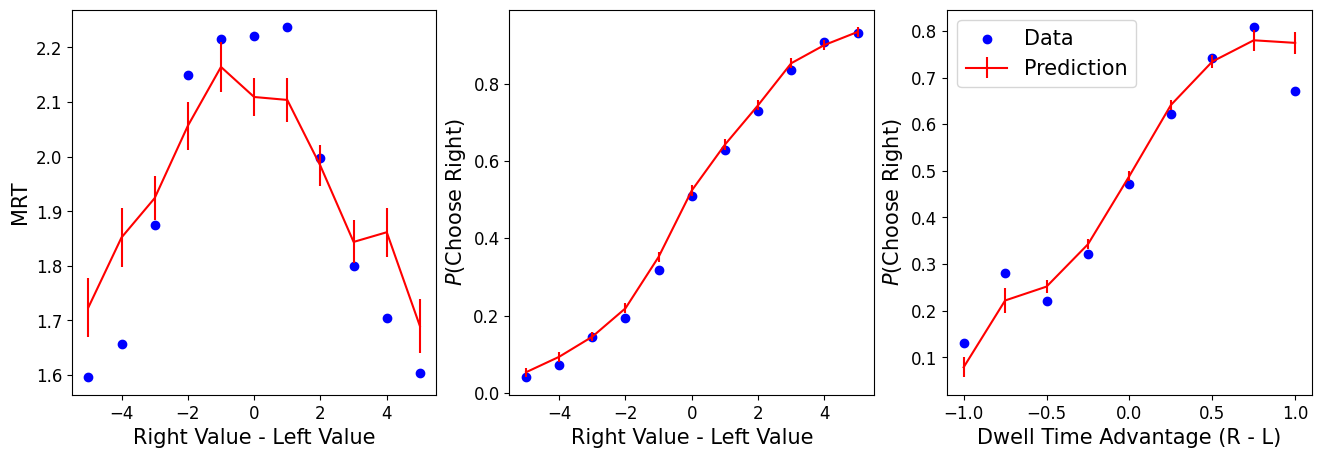

In [14]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1, c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1, 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

# plt.savefig('_plots/kr2010_complete_postpred.pdf', 
#             dpi=600, 
#             transparent=True, 
#             bbox_inches='tight');

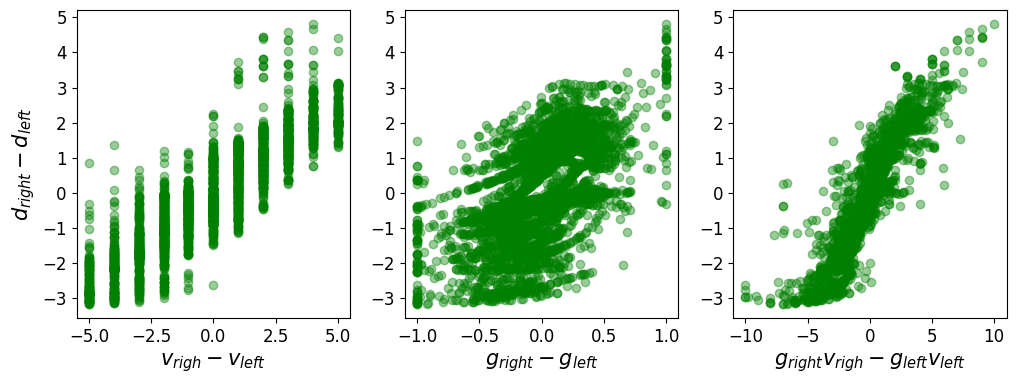

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

# plt.savefig('_plots/kr2010_complete_prmspred.pdf', 
#             dpi=600, 
#             transparent=True, 
#             bbox_inches='tight');

In [16]:
est_gp = SymbolicRegressor(population_size=5000,
                           function_set=['add', 'sub', 'mul', 'div'],
                           generations=50, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, pred_v[:, 0]-pred_v[:, 1])
print(est_gp._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    31.03           915221        7         0.645821         0.591116      2.00m
   1     8.10          3.41673        9         0.557943         0.547626      1.31m
   2     6.68          7.48815       11         0.449914         0.458252      1.11m
   3     7.85          2.96315       13         0.442017           0.4401      1.08m
   4     7.70          73.1601       13         0.439984         0.458356      1.01m
   5     7.32          1.95175        9         0.326039         0.345929     58.15s
   6     8.62          1.84499       13         0.315309         0.334776      1.00m
   7     9.36          5.62356       13         0.302454         0.315655     55.69s
   8     9.43          2.12487       13         0.293111         0.296668  